# Loading necessary libraries and preparing raw dataset:

In [167]:
%pip install ipywidgets==8.0.4 ipydatetime

!jupyter nbextension enable --py widgetsnbextension

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [168]:
#Data manipulating packages
import pandas as pd
import numpy as np
import sys, os
from numpy.polynomial.polynomial import polyfit
from scipy.stats import norm, nct
from pandas import ExcelWriter
import xlsxwriter
import io
# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import math

import ipydatetime
import ipywidgets as widgets
import datetime

In [169]:
file_path = '.\\Testing\\range_study_export.xlsx'

In [170]:
raw_df = pd.read_excel(".\\raw_data\\2021_2023_raw_data.xlsx")

In [171]:
raw_df = raw_df[raw_df['Estimated Service Range [km]'] >= 0]
display(raw_df)

,Trip Start Time,Bus Number,Fleet,Garage,OperatorID,Route Number,Run Number,Distance [km],SoC Start [%],SoC Used [%],...,Imported EnvCan Ambient Temp [C],Actual Range Safe?,Manual Range Safe?,Historical 1s-tol Range Safe?,STVmin Range Safe?,STVmax Range Safe?,Range Safe?\n(50% SSoC),Actual Range Safe?\n(50% SSoC),Manual Range Safe?\n(50% SSoC),Historical 1s-tol Range Safe?\n(50% SSoC)
0,2021-01-04 06:04:55,3700,NewFlyer SR2304,Arrow,D81195,119.0,2.0,76.375,90.4,26.0,...,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-04 14:46:03,3700,NewFlyer SR2304,Arrow,D80687,984.0,6.0,83.375,89.6,28.4,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-05 05:51:15,3700,NewFlyer SR2304,Arrow,D96696,927.0,12.0,108.375,86.8,28.4,...,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-05 14:30:44,3700,NewFlyer SR2304,Arrow,D95317,35.0,17.0,69.875,59.6,20.0,...,1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,2021-01-04 06:13:10,3701,NewFlyer SR2304,Arrow,D31908,996.0,11.0,81.875,90.4,34.0,...,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62903,2023-12-20 15:40:08,3759,BYD K9M,Eglinton,D36207,954.0,10.0,38.780,100.0,14.0,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62904,2023-12-24 06:18:32,3759,BYD K9M,Eglinton,D82658,320.0,7.0,57.645,100.0,16.0,...,3.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62905,2023-12-27 15:00:16,3759,BYD K9M,Eglinton,D31607,954.0,6.0,99.755,97.0,29.0,...,7.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62906,2023-12-28 05:25:48,3759,BYD K9M,Eglinton,D16848,67.0,9.0,67.540,100.0,23.0,...,6.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [172]:
raw_df['Trip Start Date'] = raw_df['Trip Start Time'].dt.date
default_start_date = min(raw_df['Trip Start Date'])
default_end_date = max(raw_df['Trip Start Date'])

In [173]:
start_date = widgets.DatePicker(
    description='Start Date',
    disabled=False,
    start = default_start_date,
    value = default_start_date
)
end_date = widgets.DatePicker(
    description='End Date',
    disabled=False,
    end = default_end_date,
    value = default_end_date
)

def f(start, end):
    print('start date: {}, end date: {}'.format(start, end))

out = widgets.interactive_output(f, {'start': start_date, 'end': end_date})

widgets.HBox([widgets.VBox([start_date, end_date]), out])

In [174]:
start = start_date.value
end = end_date.value
df = raw_df.copy()
mask = (df['Trip Start Date'] >= start) & (df['Trip Start Date'] <= end)
df = df.loc[mask]

# Defining the function to calculate 1-sided tolerance upper and lower bounds:

In [175]:
def one_sided_tolerance(data):
    n = len(data)
    p=0.95
    # confidence level
    g = 0.95

    # a demo sample
    x = data

    # mean estimate based on the sample
    mu_est = x.mean()

    # standard deviation estimated based on the sample
    sigma_est = x.std(ddof=1)

    # (100*p)th and (100*(1-p))th percentiles of the standard normal distribution
    zp = norm.ppf(p)
    zp_L = norm.ppf(1-p)
    # gth quantile of a non-central t distribution
    # with n-1 degrees of freedom and non-centrality parameter np.sqrt(n)*zp
    t = nct.ppf(g, df=n-1., nc=np.sqrt(n)*zp)
    t_L = nct.ppf(g, df = n-1, nc=np.sqrt(n)*zp_L)
    # k factor from Young et al paper
    k = t / np.sqrt(n)
    y_tol_U = k*sigma_est
    k_L = t_L/np.sqrt(n)
    y_tol_L = k_L*sigma_est
    # One-sided tolerance upper and lower bounds
    y_upper = mu_est + (y_tol_U)   
    y_lower = mu_est + (y_tol_L)
    return y_lower

In [176]:
def save_chart(workbook, figs, chart_name):
    wks1=workbook.add_worksheet(chart_name)
#     wks1.write(0,0,'test')
    position = 1
    for fig in figs:
        imgdata=io.BytesIO()
        fig.savefig(imgdata, format='png')
        cell_position = 'B' + str(position)
        wks1.insert_image(cell_position, '', {'image_data': imgdata})
        position = position + 28
    print('Adding chart(s) done.')

# Adding "Month" column for grouping data:

In [177]:
df['Month'] = pd.DatetimeIndex(df['Trip Start Time']).month

In [178]:
display(df[['Month', 'Trip Start Time']])

,Month,Trip Start Time
0,1,2021-01-04 06:04:55
1,1,2021-01-04 14:46:03
3,1,2021-01-05 05:51:15
4,1,2021-01-05 14:30:44
16,1,2021-01-04 06:13:10
...,...,...
62903,12,2023-12-20 15:40:08
62904,12,2023-12-24 06:18:32
62905,12,2023-12-27 15:00:16
62906,12,2023-12-28 05:25:48


# Data segmentation and filtering:

In [179]:
df1 = df[(df['SoC Start [%]'] > 50) & (df['SoC Used [%]'] > 30) & (df['Bus Number'] != 3745)
        & (df['Fleet'] == 'Proterra DuoPower') & (df['Avg ECU Ambient Temp [degC]'] < 20)]

df2 = df[(df['SoC Start [%]'] > 50) & (df['SoC Used [%]'] > 30) 
        & (df['Fleet'] == 'Proterra ProDrive') & (df['Avg ECU Ambient Temp [degC]'] < 20)]

In [180]:
# print(df1)

In [181]:
# print(df1[['Trip Start Time', 'Month']])

In [182]:
regression_params_df = pd.DataFrame()
regression_params_df['Temperture Interval'] = ['<5 degC', '5-20 degC', '<20 degC', '20-40 degC', '<5 degC', '5-20 degC', '<20 degC', '20-40 degC']
regression_params_df['fleet'] = ['DuoPower','DuoPower','DuoPower','DuoPower','ProDrive','ProDrive','ProDrive','ProDrive']
regression_params_df['slope'] = np.nan
regression_params_df['intercept'] = np.nan

# Regressional analysis of estimated range and ambient temperature:

## For data points having Avg ECU Ambient Temp [degC] under 20 degree Celsius:

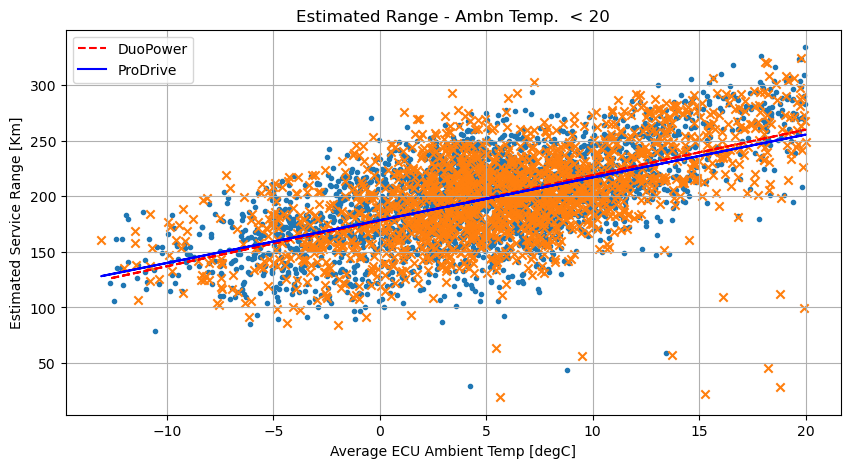

In [183]:
x1 = df1['Avg ECU Ambient Temp [degC]']
y1 = df1['Estimated Service Range [km]']
x2 = df2['Avg ECU Ambient Temp [degC]']
y2 = df2['Estimated Service Range [km]']

z1 = np.polyfit(x1, y1, 1)
p1 = np.poly1d(z1)
z2 = np.polyfit(x2, y2, 1)
p2 = np.poly1d(z2)
fig1 = plt.figure(figsize=(10,5))
plt.scatter(x1,y1, marker='.')
plt.scatter(x2,y2, marker='x')
plt.plot(x1,p1(x1),"r--", label="DuoPower")
plt.plot(x2,p2(x2),"b", label="ProDrive")
plt.legend(loc="upper left")
plt.grid()
plt.title("Estimated Range - Ambn Temp.  < 20")
plt.xlabel("Average ECU Ambient Temp [degC]")
plt.ylabel("Estimated Service Range [Km]")
plt.show()

In [184]:
print('Proterra DuoPower: Slope: {} - Intercept: {}'.format(z1[0], z1[1]))
print('Proterra ProDrive: Slope: {} - Intercept: {}'.format(z2[0], z2[1]))

Proterra DuoPower: Slope: 4.097556476521041 - Intercept: 178.04251217516514
Proterra ProDrive: Slope: 3.850243279145924 - Intercept: 178.5209768492148


In [185]:
regression_params_df.loc[(regression_params_df['Temperture Interval'] == '<20 degC') & 
                         (regression_params_df['fleet'] == 'DuoPower'),
                         ['slope','intercept']] = [z1[0], z1[1]]
regression_params_df.loc[(regression_params_df['Temperture Interval'] == '<20 degC') & 
                         (regression_params_df['fleet'] == 'ProDrive'),
                         ['slope','intercept']] = [z2[0], z2[1]]

In [186]:
display(regression_params_df)

,Temperture Interval,fleet,slope,intercept
0,<5 degC,DuoPower,NaN,NaN
1,5-20 degC,DuoPower,NaN,NaN
2,<20 degC,DuoPower,4.097556,178.042512
3,20-40 degC,DuoPower,NaN,NaN
4,<5 degC,ProDrive,NaN,NaN
5,5-20 degC,ProDrive,NaN,NaN
6,<20 degC,ProDrive,3.850243,178.520977
7,20-40 degC,ProDrive,NaN,NaN


## For data points having Avg ECU Ambient Temp [degC] between 5 and 20 degree Celsius:

In [187]:
df3 = df[(df['SoC Start [%]'] > 50) & (df['SoC Used [%]'] > 30) & (df['Bus Number'] != 3745)
        & (df['Fleet'] == 'Proterra DuoPower') & (df['Avg ECU Ambient Temp [degC]'] < 20)
        & (df['Avg ECU Ambient Temp [degC]'] > 5)]

df4 = df[(df['SoC Start [%]'] > 50) & (df['SoC Used [%]'] > 30) 
        & (df['Fleet'] == 'Proterra ProDrive') & (df['Avg ECU Ambient Temp [degC]'] < 20)
        & (df['Avg ECU Ambient Temp [degC]'] > 5)]

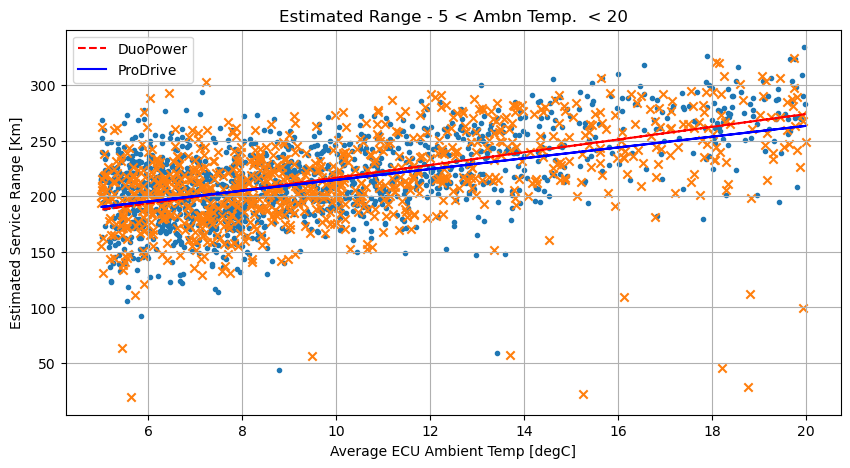

In [188]:
x3 = df3['Avg ECU Ambient Temp [degC]']
y3 = df3['Estimated Service Range [km]']
x4 = df4['Avg ECU Ambient Temp [degC]']
y4 = df4['Estimated Service Range [km]']

z3 = np.polyfit(x3, y3, 1)
p3 = np.poly1d(z3)
z4 = np.polyfit(x4, y4, 1)
p4 = np.poly1d(z4)
fig2 = plt.figure(figsize=(10,5))
plt.scatter(x3,y3, marker='.')
plt.scatter(x4,y4, marker='x')
plt.plot(x3,p3(x3),"r--", label="DuoPower")
plt.plot(x4,p4(x4),"b", label="ProDrive")
plt.legend(loc="upper left")
plt.grid()
plt.title("Estimated Range - 5 < Ambn Temp.  < 20")
plt.xlabel("Average ECU Ambient Temp [degC]")
plt.ylabel("Estimated Service Range [Km]")
plt.show()

In [189]:
print('Proterra DuoPower: Slope: {} - Intercept: {}'.format(z3[0], z3[1]))
print('Proterra ProDrive: Slope: {} - Intercept: {}'.format(z4[0], z4[1]))

Proterra DuoPower: Slope: 5.727244153041212 - Intercept: 159.4135577960157
Proterra ProDrive: Slope: 4.863223846518555 - Intercept: 166.12699272338673


In [190]:
regression_params_df.loc[(regression_params_df['Temperture Interval'] == '5-20 degC') & 
                         (regression_params_df['fleet'] == 'DuoPower'),
                         ['slope','intercept']] = [z3[0], z3[1]]
regression_params_df.loc[(regression_params_df['Temperture Interval'] == '5-20 degC') & 
                         (regression_params_df['fleet'] == 'ProDrive'),
                         ['slope','intercept']] = [z4[0], z4[1]]

## For data points having Avg ECU Ambient Temp [degC] under 5 degree Celsius:

In [191]:
df5 = df[(df['SoC Start [%]'] > 50) & (df['SoC Used [%]'] > 30) & (df['Bus Number'] != 3745)
        & (df['Fleet'] == 'Proterra DuoPower') & (df['Avg ECU Ambient Temp [degC]'] < 5)]

df6 = df[(df['SoC Start [%]'] > 50) & (df['SoC Used [%]'] > 30) 
        & (df['Fleet'] == 'Proterra ProDrive') & (df['Avg ECU Ambient Temp [degC]'] < 5)]

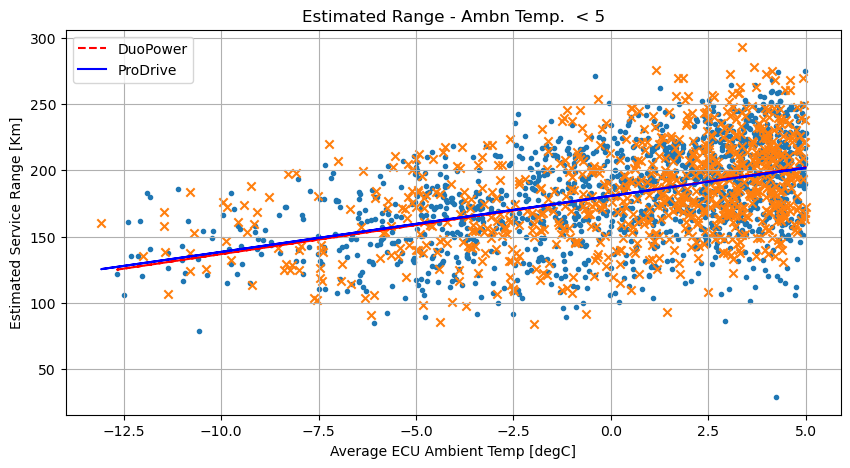

In [192]:
x5 = df5['Avg ECU Ambient Temp [degC]']
y5 = df5['Estimated Service Range [km]']
x6 = df6['Avg ECU Ambient Temp [degC]']
y6 = df6['Estimated Service Range [km]']

z5 = np.polyfit(x5, y5, 1)
p5 = np.poly1d(z5)
z6 = np.polyfit(x6, y6, 1)
p6 = np.poly1d(z6)
fig3 = plt.figure(figsize=(10,5))
plt.scatter(x5,y5, marker='.')
plt.scatter(x6,y6, marker='x')
plt.plot(x5,p5(x5),"r--", label="DuoPower")
plt.plot(x6,p6(x6),"b", label="ProDrive")
plt.legend(loc="upper left")
plt.grid()
plt.title("Estimated Range - Ambn Temp.  < 5")
plt.xlabel("Average ECU Ambient Temp [degC]")
plt.ylabel("Estimated Service Range [Km]")
plt.show()

In [193]:
print('Proterra DuoPower: Slope: {} - Intercept: {}'.format(z5[0], z5[1]))
print('Proterra ProDrive: Slope: {} - Intercept: {}'.format(z6[0], z6[1]))

Proterra DuoPower: Slope: 4.378218832852455 - Intercept: 180.65476252439655
Proterra ProDrive: Slope: 4.222201593983281 - Intercept: 180.74516965212823


In [194]:
regression_params_df.loc[(regression_params_df['Temperture Interval'] == '<5 degC') & 
                         (regression_params_df['fleet'] == 'DuoPower'),
                         ['slope','intercept']] = [z5[0], z5[1]]
regression_params_df.loc[(regression_params_df['Temperture Interval'] == '<5 degC') & 
                         (regression_params_df['fleet'] == 'ProDrive'),
                         ['slope','intercept']] = [z6[0], z6[1]]

## For data points having Avg ECU Ambient Temp [degC] between 20 and 40 degree Celsius:

In [195]:
df7 = df[(df['SoC Start [%]'] > 50) & (df['SoC Used [%]'] > 30) & (df['Bus Number'] != 3745)
        & (df['Fleet'] == 'Proterra DuoPower') & (df['Avg ECU Ambient Temp [degC]'] < 40)
        & (df['Avg ECU Ambient Temp [degC]'] > 20)]

df8 = df[(df['SoC Start [%]'] > 50) & (df['SoC Used [%]'] > 30) 
        & (df['Fleet'] == 'Proterra ProDrive') & (df['Avg ECU Ambient Temp [degC]'] < 40)
        & (df['Avg ECU Ambient Temp [degC]'] > 20)]

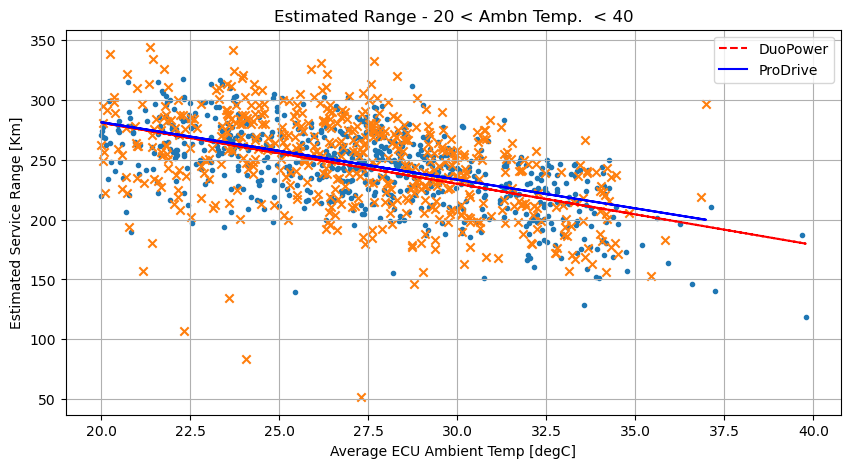

In [196]:
x7 = df7['Avg ECU Ambient Temp [degC]']
y7 = df7['Estimated Service Range [km]']
x8 = df8['Avg ECU Ambient Temp [degC]']
y8 = df8['Estimated Service Range [km]']

z7 = np.polyfit(x7, y7, 1)
p7 = np.poly1d(z7)
z8 = np.polyfit(x8, y8, 1)
p8 = np.poly1d(z8)
fig4 = plt.figure(figsize=(10,5))
plt.scatter(x7,y7, marker='.')
plt.scatter(x8,y8, marker='x')
plt.plot(x7,p7(x7),"r--", label="DuoPower")
plt.plot(x8,p8(x8),"b", label="ProDrive")
plt.legend(loc="upper right")
plt.grid()
plt.title("Estimated Range - 20 < Ambn Temp.  < 40")
plt.xlabel("Average ECU Ambient Temp [degC]")
plt.ylabel("Estimated Service Range [Km]")
plt.show()


In [197]:
print('Proterra DuoPower: Slope: {} - Intercept: {}'.format(z7[0], z7[1]))
print('Proterra ProDrive: Slope: {} - Intercept: {}'.format(z8[0], z8[1]))

Proterra DuoPower: Slope: -5.113125696632565 - Intercept: 383.38133062010775
Proterra ProDrive: Slope: -4.804647877453648 - Intercept: 377.6167333166602


In [198]:
regression_params_df.loc[(regression_params_df['Temperture Interval'] == '20-40 degC') & 
                         (regression_params_df['fleet'] == 'DuoPower'),
                         ['slope','intercept']] = [z7[0], z7[1]]
regression_params_df.loc[(regression_params_df['Temperture Interval'] == '20-40 degC') & 
                         (regression_params_df['fleet'] == 'ProDrive'),
                         ['slope','intercept']] = [z8[0], z8[1]]

In [199]:
display(regression_params_df)

,Temperture Interval,fleet,slope,intercept
0,<5 degC,DuoPower,4.378219,180.654763
1,5-20 degC,DuoPower,5.727244,159.413558
2,<20 degC,DuoPower,4.097556,178.042512
3,20-40 degC,DuoPower,-5.113126,383.381331
4,<5 degC,ProDrive,4.222202,180.745170
5,5-20 degC,ProDrive,4.863224,166.126993
6,<20 degC,ProDrive,3.850243,178.520977
7,20-40 degC,ProDrive,-4.804648,377.616733


# Calculating ambient temperature and estimated range:

In [200]:
df9 = df[(df['SoC Start [%]'] > 50) & (df['SoC Used [%]'] > 30) & (df['Bus Number'] != 3745)
        & (df['Fleet'] == 'Proterra DuoPower') & (df['Avg ECU Ambient Temp [degC]'] > 19)
        & (df['Avg ECU Ambient Temp [degC]'] < 21)]

df10 = df[(df['SoC Start [%]'] > 50) & (df['SoC Used [%]'] > 30) & (df['Bus Number'] != 3745)
        & (df['Fleet'] == 'Proterra ProDrive') & (df['Avg ECU Ambient Temp [degC]'] > 19)
        & (df['Avg ECU Ambient Temp [degC]'] < 21)]

In [201]:
df11 = df[(df['SoC Start [%]'] > 85) & (df['SoC Used [%]'] > 30) & (df['Bus Number'] != 3745)
        & (df['Fleet'] == 'Proterra DuoPower') & (df['Avg ECU Ambient Temp [degC]'] > 19)
        & (df['Avg ECU Ambient Temp [degC]'] < 21)]

In [202]:
df12 = df[(df['SoC Start [%]'] > 85) 
          & (df['Fleet'] == 'Proterra DuoPower') 
          & (df['SoC Used [%]'] > 30) 
          & (df['Bus Number'] != 3745)]

## Calculating average ambient temperature by month:

In [203]:
avg_monthly = pd.DataFrame()
avg_monthly = df12.groupby(['Fleet','Month'], as_index=False).agg(
     _col1 = ("Avg ECU Ambient Temp [degC]",'mean'),
     _col2 = ("Imported EnvCan Ambient Temp [C]",'mean')    
     )
avg_monthly.rename(columns={'_col1': 'AmbTavg [°C]', '_col2': 'EnvCan [°C]'}, inplace=True)

In [204]:
df13 = df[(df['SoC Start [%]'] > 50) & (df['SoC Used [%]'] > 30) & (df['Bus Number'] != 3745)
        & (df['Fleet'] == 'Proterra DuoPower')]

In [205]:
avg_temp_monthly = avg_monthly[(avg_monthly['Fleet'].isin(['Proterra DuoPower','Proterra ProDrive']))].sort_values(['Fleet', 'Month'], ascending=[True, True])

In [206]:
count = []
p95_ambt = []
for i in range(1, 13):
    tmp = df13.copy()
    x = tmp[(tmp['Month'] == i)]['Avg ECU Ambient Temp [degC]']
    if(x.mean() < 20):
        upper = x.quantile(0.05)
        x = x[(x >= upper)]
    elif (x.mean() >= 20):
        upper = x.quantile(0.95)
        x = x[(x <= upper)]
    count.append(x.count())
    p95_ambt.append(upper)
    
avg_temp_monthly['95% AmbT'] = p95_ambt
avg_temp_monthly['Count'] = count

### Monthly average ambient temperature data table:

In [207]:
display(avg_temp_monthly)

,Fleet,Month,AmbTavg [°C],EnvCan [°C],95% AmbT,Count
0,Proterra DuoPower,1,0.109550,-3.504528,-9.083256,556
1,Proterra DuoPower,2,1.535353,-2.835714,-6.632107,478
2,Proterra DuoPower,3,6.448721,1.745576,-2.387621,391
3,Proterra DuoPower,4,11.522865,7.579528,4.613920,267
4,Proterra DuoPower,5,18.422452,14.499492,7.850384,214
5,Proterra DuoPower,6,26.436954,23.327200,34.069338,142
6,Proterra DuoPower,7,28.412008,25.247552,33.851335,152
7,Proterra DuoPower,8,27.659532,24.581022,32.866465,161
8,Proterra DuoPower,9,21.275626,18.990826,29.990435,126
9,Proterra DuoPower,10,12.696185,10.489222,6.378216,179


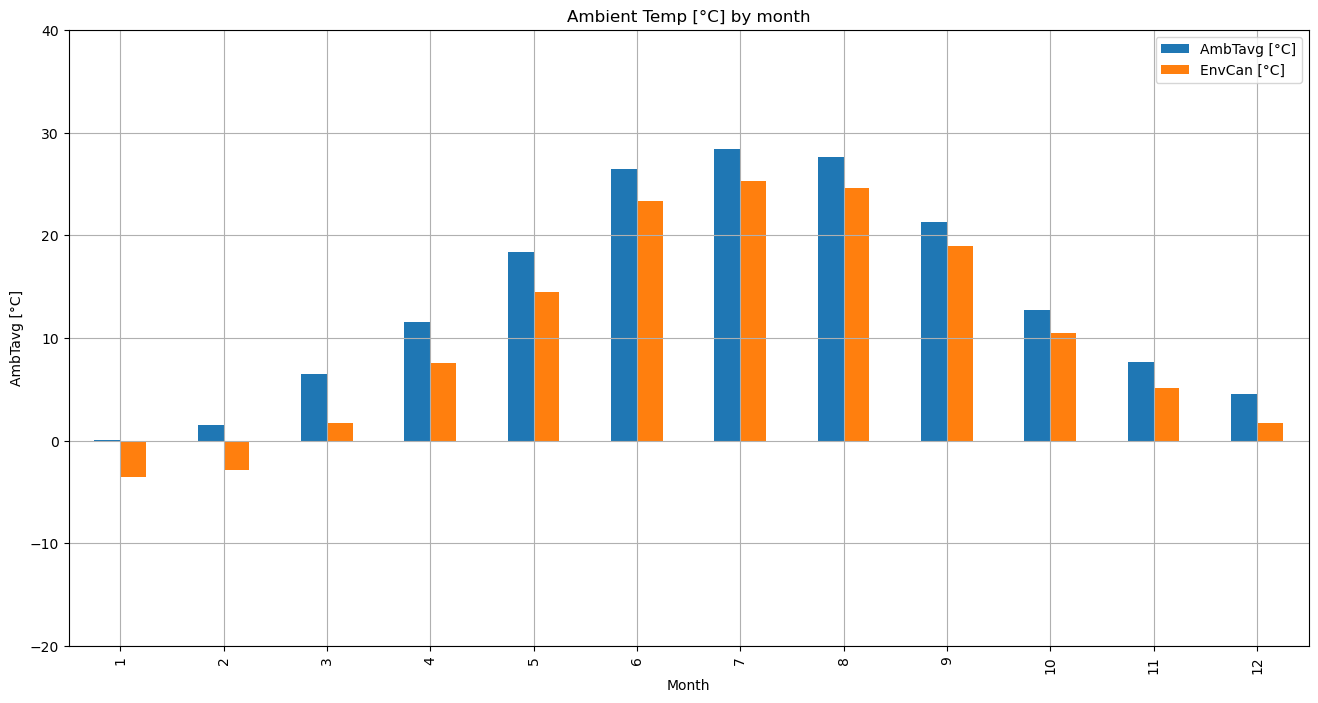

In [208]:
lst = ["AmbTavg [°C]","EnvCan [°C]"]
chart_fig1 = plt.figure()
ax1=chart_fig1.add_subplot()
avg_temp_monthly.plot(x="Month", y=lst, kind='bar', ax=ax1, 
                   figsize=(16,8), ylabel='AmbTavg [°C]',grid=True, title="Ambient Temp [°C] by month", ylim=(-20,40))

# plt.figure(figsize=(12,4))
plt.show()

## Calculating estimated service range of e-buses (except bus 3745):

In [209]:
estimation_df = pd.DataFrame()
estimation_df['Month'] = [*range(1, 13, 1)]

In [210]:
one_sided_estimation = []
for i in range(1, 13):
    tmp = df13.copy()
    x = tmp[(tmp['Month'] == i)]['Estimated Service Range [km]']
    y_lower = one_sided_tolerance(x)
    one_sided_estimation.append(y_lower)
#     print('{} - {}'.format(i, y_lower))

In [211]:
estimation_df['one_sided_estimation'] = one_sided_estimation
# print(estimation_df)

In [212]:
tmp = df9.copy()
x = tmp['Estimated Service Range [km]'].dropna()
p95_range_mean = x.mean()
p5_quantile = x.quantile(0.05)
lower_y = one_sided_tolerance(x)
# print(lower_y)

In [213]:
lst = avg_temp_monthly['95% AmbT'].to_list()
results = []
x1 = regression_params_df[(regression_params_df['Temperture Interval'] == '<5 degC')
                          & (regression_params_df['fleet'] == 'DuoPower')]['slope'].iloc[0]
# print(x1)
x2 = regression_params_df[(regression_params_df['Temperture Interval'] == '5-20 degC')
                          & (regression_params_df['fleet'] == 'DuoPower')]['slope'].iloc[0]
# print(x2)
x3 = regression_params_df[(regression_params_df['Temperture Interval'] == '20-40 degC')
                          & (regression_params_df['fleet'] == 'DuoPower')]['slope'].iloc[0]
# print(x3)
counter = 1
for i in lst:    
    result = 0
#     print(i)
    if i<5:
        result = p95_range_mean-(15*x2)+(i-5)*x1
    elif (i>=5) & (i <= 20):
        result = p95_range_mean+(i-20)*x2
    elif (i>20) & (i<=40):
        result = p95_range_mean+(i-20)*x3
    else:
        result = 0
    print('{} - {} - {}'.format(counter, i, result))
    counter = counter+1
    results.append(result)

1 - -9.083256440138918 - 122.59755696003145
2 - -6.6321072166135275 - 133.329224652602
3 - -2.387621323969327 - 151.9125127235534
4 - 4.61391996714065 - 182.56679266328518
5 - 7.8503836272596805 - 200.5819784972857
6 - 34.06933848935114 - 198.22750166523355
7 - 33.85133541498909 - 199.34217878669907
8 - 32.866464995830896 - 204.3779450347501
9 - 29.990435064563012 - 219.0834475806003
10 - 6.378216274552506 - 192.15051663419536
11 - 0.5826593962522565 - 164.91705171168607
12 - -0.6677684312863116 - 159.44240504803395


In [214]:
estimation_df['95% AmbT with Avg. Nom. Range'] = results

In [215]:
lst = avg_temp_monthly['AmbTavg [°C]'].to_list()
results = []
x1 = regression_params_df[(regression_params_df['Temperture Interval'] == '<5 degC')
                          & (regression_params_df['fleet'] == 'DuoPower')]['slope'].iloc[0]
# print(x1)
x2 = regression_params_df[(regression_params_df['Temperture Interval'] == '5-20 degC')
                          & (regression_params_df['fleet'] == 'DuoPower')]['slope'].iloc[0]
# print(x2)
x3 = regression_params_df[(regression_params_df['Temperture Interval'] == '20-40 degC')
                          & (regression_params_df['fleet'] == 'DuoPower')]['slope'].iloc[0]
# print(x3)
counter = 1
for i in lst:    
    result = 0
#     print(i)
    if i<5:
        result = p5_quantile-(15*x2)+(i-5)*x1
    elif (i>=5) & (i <= 20):
        result = p5_quantile+(i-20)*x2
    elif (i>20) & (i<=40):
        result = p5_quantile+(i-20)*x3
    else:
        result = 0
    print('{} - {} - {}'.format(counter, i, result))
    counter = counter+1
    results.append(result)

estimation_df['Avg AmbT DuoPower'] = results

1 - 0.10954978772343853 - 101.9970560213792
2 - 1.5353530884921966 - 108.23953488474817
3 - 6.448720681875922 - 131.7056942965595
4 - 11.52286476724967 - 160.76655634120493
5 - 18.42245187316238 - 200.28217625194205
6 - 26.43695424644628 - 176.40422337196134
7 - 28.4120080073432 - 166.30552523488848
8 - 27.65953201284925 - 170.15302957843465
9 - 21.275626352256904 - 202.79474165648747
10 - 12.696184889569901 - 167.48644715140907
11 - 7.614261577532322 - 138.381031576338
12 - 4.526226780203446 - 121.33423440848131


In [216]:
tmp = df10.copy()
x = tmp['Estimated Service Range [km]'].dropna()
p95_range_mean = x.mean()
p5_quantile = x.quantile(0.05)
lower_y = one_sided_tolerance(x)

lst = avg_temp_monthly['AmbTavg [°C]'].to_list()
results = []
x1 = regression_params_df[(regression_params_df['Temperture Interval'] == '<5 degC')
                          & (regression_params_df['fleet'] == 'ProDrive')]['slope'].iloc[0]
# print(x1)
x2 = regression_params_df[(regression_params_df['Temperture Interval'] == '5-20 degC')
                          & (regression_params_df['fleet'] == 'ProDrive')]['slope'].iloc[0]
# print(x2)
x3 = regression_params_df[(regression_params_df['Temperture Interval'] == '20-40 degC')
                          & (regression_params_df['fleet'] == 'ProDrive')]['slope'].iloc[0]
# print(x3)
counter = 1
for i in lst:    
    result = 0
#     print(i)
    if i<5:
        result = p5_quantile-(15*x2)+(i-5)*x1
    elif (i>=5) & (i <= 20):
        result = p5_quantile+(i-20)*x2
    elif (i>20) & (i<=40):
        result = p5_quantile+(i-20)*x3
    else:
        result = 0
    print('{} - {} - {}'.format(counter, i, result))
    counter = counter+1
    results.append(result)

estimation_df['Avg AmbT ProDrive'] = results

1 - 0.10954978772343853 - 125.0381679384167
2 - 1.5353530884921966 - 131.05819690762917
3 - 6.448720681875922 - 152.7320875870303
4 - 11.52286476724967 - 177.408786103691
5 - 18.42245187316238 - 210.96302264829762
6 - 26.43695424644628 - 187.70769376031063
7 - 28.4120080073432 - 178.21825590016041
8 - 27.65953201284925 - 181.8336380899406
9 - 21.275626352256904 - 212.50605687196995
10 - 12.696184889569901 - 183.1149045021588
11 - 7.614261577532322 - 158.4003738648791
12 - 4.526226780203446 - 143.68626857617508


### Monthly estimated service range data table: 

In [217]:
display(estimation_df)

,Month,one_sided_estimation,95% AmbT with Avg. Nom. Range,Avg AmbT DuoPower,Avg AmbT ProDrive
0,1,115.842399,122.597557,101.997056,125.038168
1,2,129.627128,133.329225,108.239535,131.058197
2,3,159.375823,151.912513,131.705694,152.732088
3,4,165.122665,182.566793,160.766556,177.408786
4,5,189.684512,200.581978,200.282176,210.963023
5,6,203.584637,198.227502,176.404223,187.707694
6,7,194.559332,199.342179,166.305525,178.218256
7,8,190.368231,204.377945,170.153030,181.833638
8,9,207.940762,219.083448,202.794742,212.506057
9,10,168.072522,192.150517,167.486447,183.114905


### Monthly estimated service range data visualization: 

In [218]:
manual_pick_df = pd.DataFrame()
manual_pick_df['total'] = df13.groupby(['Month'])['Estimated Service Range [km]'].count()
manual_pick_df['p95_threshold_count'] = np.ceil(manual_pick_df['total']*0.95).astype(int)
display(manual_pick_df)

,total,p95_threshold_count
Month,,
1,586,557
2,504,479
3,412,392
4,281,267
5,226,215
6,150,143
7,160,152
8,170,162
9,133,127


In [219]:
tmp_arr = []
for i in range(1,13):
    temp = df13[df13['Month'] == i]
    condition = manual_pick_df.iloc[i-1]['p95_threshold_count']
#     print(condition)
    limit = 0
#     print(limit)
    counter = temp['Estimated Service Range [km]'].count()
    while counter > condition:
        limit = limit + 1
        counter = temp[temp['Estimated Service Range [km]'] > limit]['Estimated Service Range [km]'].count()
        if counter <= condition:
            tmp_arr.append(limit)
            break        
#         print('{} - {} - {} - {}'.format(i, counter, manual_pick_df.iloc[i-1]['p95_threshold_count'],limit))        

manual_pick_df['p95_threshold'] = tmp_arr

In [220]:
display(manual_pick_df)

,total,p95_threshold_count,p95_threshold
Month,,,
1,586,557,111
2,504,479,126
3,412,392,155
4,281,267,168
5,226,215,184
6,150,143,184
7,160,152,188
8,170,162,182
9,133,127,195


In [221]:
estimation_df['Manually picked range'] = manual_pick_df['p95_threshold'].tolist()
estimation_df['Manually_picked_service_coverage'] = (manual_pick_df['p95_threshold_count']/manual_pick_df['total']).tolist()

In [222]:
display(estimation_df)

,Month,one_sided_estimation,95% AmbT with Avg. Nom. Range,Avg AmbT DuoPower,Avg AmbT ProDrive,Manually picked range,Manually_picked_service_coverage
0,1,115.842399,122.597557,101.997056,125.038168,111,0.950512
1,2,129.627128,133.329225,108.239535,131.058197,126,0.950397
2,3,159.375823,151.912513,131.705694,152.732088,155,0.951456
3,4,165.122665,182.566793,160.766556,177.408786,168,0.950178
4,5,189.684512,200.581978,200.282176,210.963023,184,0.951327
5,6,203.584637,198.227502,176.404223,187.707694,184,0.953333
6,7,194.559332,199.342179,166.305525,178.218256,188,0.950000
7,8,190.368231,204.377945,170.153030,181.833638,182,0.952941
8,9,207.940762,219.083448,202.794742,212.506057,195,0.954887
9,10,168.072522,192.150517,167.486447,183.114905,171,0.952381


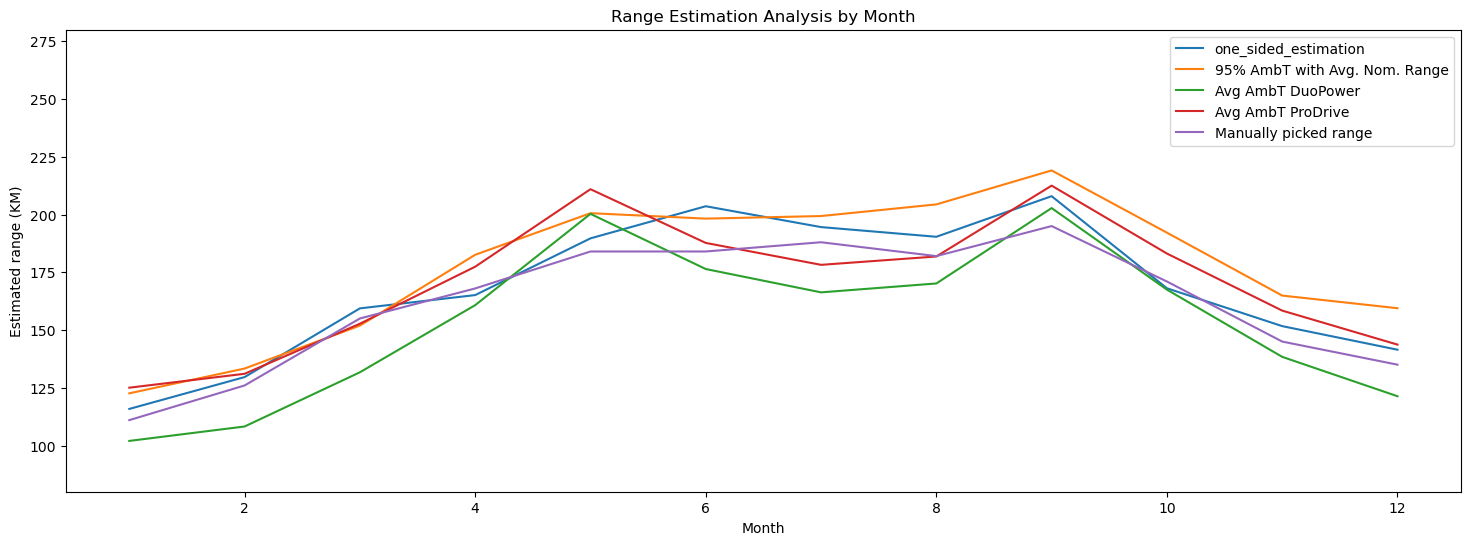

In [223]:
lst = ["one_sided_estimation", "95% AmbT with Avg. Nom. Range","Avg AmbT DuoPower", "Avg AmbT ProDrive", "Manually picked range"]
chart_fig2 = plt.figure()
ax1=chart_fig2.add_subplot()
# ax = plt.gca()
estimation_df.plot(x="Month", y=lst, ax=ax1, 
                   figsize=(18,6), ylabel='Estimated range (KM)', title="Range Estimation Analysis by Month", ylim=(80,280))

# plt.figure(figsize=(12,4))
plt.show()

### Ambient temperature time series data visualization: 

In [224]:
temperature_series_df = df[['Trip Start Time','Avg ECU Ambient Temp [degC]','Imported EnvCan Ambient Temp [C]']]

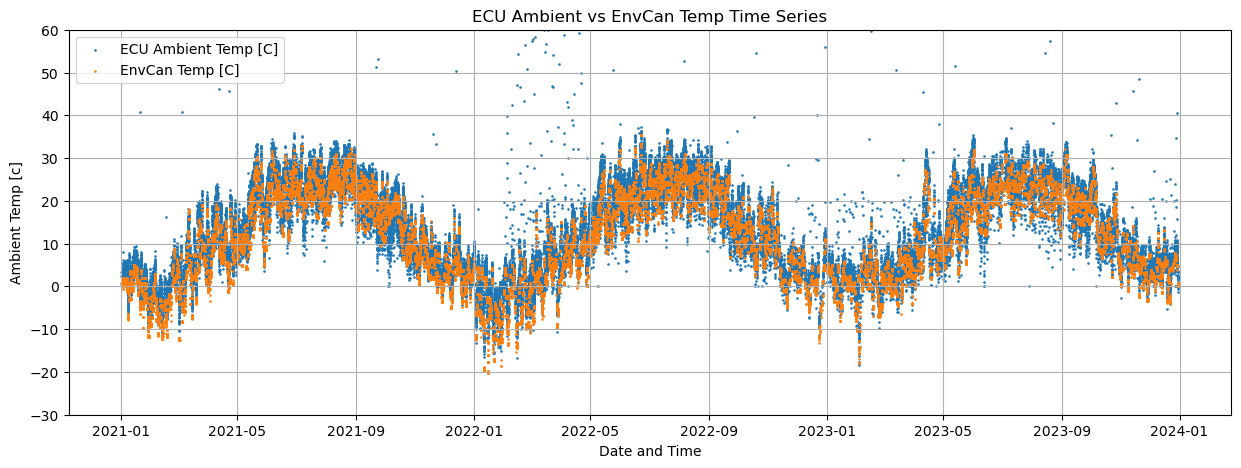

In [225]:
chart_fig3 = plt.figure(figsize=(15,5))
plt.scatter(temperature_series_df['Trip Start Time'],temperature_series_df['Avg ECU Ambient Temp [degC]'], s=3, marker='.')
plt.scatter(temperature_series_df['Trip Start Time'],temperature_series_df['Imported EnvCan Ambient Temp [C]'], s=3, marker='.')
plt.grid()
plt.ylim(-30, 60)
plt.legend(["ECU Ambient Temp [C]", "EnvCan Temp [C]"])
plt.title("ECU Ambient vs EnvCan Temp Time Series")
plt.xlabel("Date and Time")
plt.ylabel("Ambient Temp [c]")
plt.show()

In [226]:
print(df13.columns)

Index(['Trip Start Time', 'Bus Number', 'Fleet', 'Garage', 'OperatorID',
       'Route Number', 'Run Number', 'Distance [km]', 'SoC Start [%]',
       'SoC Used [%]',
       ...
       'Actual Range Safe?', 'Manual Range Safe?',
       'Historical 1s-tol Range Safe?', 'STVmin Range Safe?',
       'STVmax Range Safe?', 'Range Safe?\n(50% SSoC)',
       'Actual Range Safe?\n(50% SSoC)', 'Manual Range Safe?\n(50% SSoC)',
       'Historical 1s-tol Range Safe?\n(50% SSoC)', 'Trip Start Date'],
      dtype='object', length=132)


In [227]:
df13 = df[(df['SoC Start [%]'] > 50) & (df['SoC Used [%]'] > 30) & (df['Bus Number'] != 3745)
        & (df['Fleet'] == 'Proterra DuoPower')]

total = df13.groupby(['Fleet','Month'], as_index=False).size()
count = df13[df13['Manual Range Safe?\n(50% SSoC)'] == 'OK'].groupby(['Fleet','Month'], as_index=False)['Manual Range Safe?\n(50% SSoC)'].size()

df13['one_sided_range_safe'] = ''
df13['avg_ambt_range_safe'] = ''
df13['p95_range_safe'] = ''
df13['manually_picked_range_safe'] = ''

for index, row in df13.iterrows():
    df13.loc[index, 'one_sided_range_safe'] = 'OK' if (row['Estimated Service Range [km]'] >= estimation_df[estimation_df['Month'] == row['Month']]['one_sided_estimation'].iloc[0]) else 'OOR'
    df13.loc[index, 'avg_ambt_range_safe'] = 'OK' if (row['Estimated Service Range [km]'] >= estimation_df[estimation_df['Month'] == row['Month']]['Avg AmbT DuoPower'].iloc[0]) else 'OOR'
    df13.loc[index, 'p95_range_safe'] = 'OK' if (row['Estimated Service Range [km]'] >= estimation_df[estimation_df['Month'] == row['Month']]['95% AmbT with Avg. Nom. Range'].iloc[0]) else 'OOR'
    df13.loc[index, 'manually_picked_range_safe'] = 'OK' if (row['Estimated Service Range [km]'] >= estimation_df[estimation_df['Month'] == row['Month']]['Manually picked range'].iloc[0]) else 'OOR'

C:\Users\hotran\AppData\Local\Temp\5\ipykernel_10836\490016589.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df13['one_sided_range_safe'] = ''
C:\Users\hotran\AppData\Local\Temp\5\ipykernel_10836\490016589.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df13['avg_ambt_range_safe'] = ''
C:\Users\hotran\AppData\Local\Temp\5\ipykernel_10836\490016589.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [228]:
display(df13)

,Trip Start Time,Bus Number,Fleet,Garage,OperatorID,Route Number,Run Number,Distance [km],SoC Start [%],SoC Used [%],...,STVmax Range Safe?,Range Safe?\n(50% SSoC),Actual Range Safe?\n(50% SSoC),Manual Range Safe?\n(50% SSoC),Historical 1s-tol Range Safe?\n(50% SSoC),Trip Start Date,one_sided_range_safe,avg_ambt_range_safe,p95_range_safe,manually_picked_range_safe
4303,2021-03-01 05:36:03,3735,Proterra DuoPower,MtDennis,D34477,32.0,39.0,72.785001,100.000000,35.971875,...,NaN,NaN,NaN,NaN,NaN,2021-03-01,OK,OK,OK,OK
4305,2021-03-02 05:21:20,3735,Proterra DuoPower,MtDennis,D90997,71.0,5.0,44.455001,100.000000,33.567187,...,NaN,NaN,NaN,NaN,NaN,2021-03-02,OOR,OOR,OOR,OOR
4306,2021-03-02 14:17:10,3735,Proterra DuoPower,MtDennis,D00677,6.0,5.0,56.745001,93.698438,40.632813,...,NaN,NaN,NaN,NaN,NaN,2021-03-02,OOR,OOR,OOR,OOR
4308,2021-03-03 05:17:19,3735,Proterra DuoPower,MtDennis,D14937,79.0,7.0,94.790001,100.000000,44.065625,...,NaN,NaN,NaN,NaN,NaN,2021-03-03,OK,OK,OK,OK
4311,2021-03-04 04:38:02,3735,Proterra DuoPower,MtDennis,D74167,32.0,30.0,89.225001,100.000000,62.023437,...,NaN,NaN,NaN,NaN,NaN,2021-03-04,OOR,OOR,OOR,OOR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62721,2023-12-21 06:02:56,3749,Proterra DuoPower,MtDennis,D65897,945.0,35.0,84.785001,100.000000,35.307812,...,NaN,NaN,NaN,NaN,NaN,2023-12-21,OK,OK,OK,OK
62722,2023-12-22 05:37:57,3749,Proterra DuoPower,MtDennis,D84956,79.0,9.0,63.485001,83.265625,30.050000,...,NaN,NaN,NaN,NaN,NaN,2023-12-22,OK,OK,OK,OK
62723,2023-12-22 14:28:47,3749,Proterra DuoPower,MtDennis,D82086,945.0,36.0,123.735002,100.000000,50.159375,...,NaN,NaN,NaN,NaN,NaN,2023-12-22,OK,OK,OK,OK
62728,2023-12-28 05:03:56,3749,Proterra DuoPower,MtDennis,D79897,79.0,7.0,76.800001,100.000000,30.945312,...,NaN,NaN,NaN,NaN,NaN,2023-12-28,OK,OK,OK,OK


In [229]:
temp_rc = pd.DataFrame()
temp_rc['one_sided_service_coverage'] = df13[df13['one_sided_range_safe'] == 'OK'].groupby(['Month'])['one_sided_range_safe'].count()/df13.groupby(['Month'])['one_sided_range_safe'].count()
temp_rc['avg_ambt_service_coverage'] = df13[df13['avg_ambt_range_safe'] == 'OK'].groupby(['Month'])['avg_ambt_range_safe'].count()/df13.groupby(['Month'])['avg_ambt_range_safe'].count()
temp_rc['p95_service_coverage'] = df13[df13['p95_range_safe'] == 'OK'].groupby(['Month'])['p95_range_safe'].count()/df13.groupby(['Month'])['p95_range_safe'].count()

estimation_df = estimation_df.merge(temp_rc, how='inner', on='Month')

In [230]:
display(estimation_df)

,Month,one_sided_estimation,95% AmbT with Avg. Nom. Range,Avg AmbT DuoPower,Avg AmbT ProDrive,Manually picked range,Manually_picked_service_coverage,one_sided_service_coverage,avg_ambt_service_coverage,p95_service_coverage
0,1,115.842399,122.597557,101.997056,125.038168,111,0.950512,0.928328,0.979522,0.892491
1,2,129.627128,133.329225,108.239535,131.058197,126,0.950397,0.932540,0.988095,0.910714
2,3,159.375823,151.912513,131.705694,152.732088,155,0.951456,0.929612,0.980583,0.961165
3,4,165.122665,182.566793,160.766556,177.408786,168,0.950178,0.953737,0.960854,0.839858
4,5,189.684512,200.581978,200.282176,210.963023,184,0.951327,0.933628,0.853982,0.849558
5,6,203.584637,198.227502,176.404223,187.707694,184,0.953333,0.893333,0.973333,0.920000
6,7,194.559332,199.342179,166.305525,178.218256,188,0.950000,0.937500,0.975000,0.912500
7,8,190.368231,204.377945,170.153030,181.833638,182,0.952941,0.923529,0.976471,0.864706
8,9,207.940762,219.083448,202.794742,212.506057,195,0.954887,0.932331,0.939850,0.879699
9,10,168.072522,192.150517,167.486447,183.114905,171,0.952381,0.984127,0.989418,0.777778


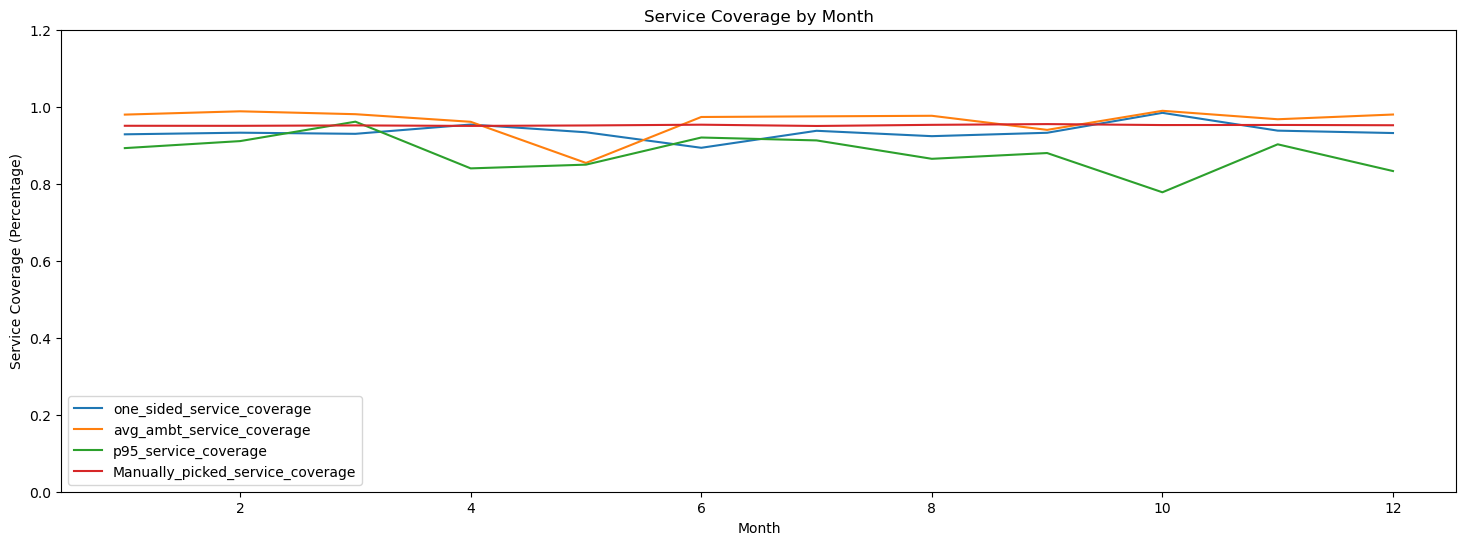

In [231]:
lst = ["one_sided_service_coverage", "avg_ambt_service_coverage","p95_service_coverage", "Manually_picked_service_coverage"]
chart_fig4 = plt.figure()
ax1=chart_fig4.add_subplot()
estimation_df.plot(x="Month", y=lst, ax=ax1, 
                   figsize=(18,6), ylabel='Service Coverage (Percentage)', title="Service Coverage by Month", ylim=(0,1.2))
# plt.figure(figsize=(12,4))
plt.show()

In [232]:
missed_service_count_df = pd.DataFrame()
missed_service_count_df['one_sided'] = df13[df13['one_sided_range_safe'] == 'OOR'].groupby(['Month'])['one_sided_range_safe'].count()
missed_service_count_df['avg_ambt'] = df13[df13['avg_ambt_range_safe'] == 'OOR'].groupby(['Month'])['avg_ambt_range_safe'].count()
missed_service_count_df['p95'] = df13[df13['p95_range_safe'] == 'OOR'].groupby(['Month'])['p95_range_safe'].count()
missed_service_count_df['manually_picked'] = df13[df13['manually_picked_range_safe'] == 'OOR'].groupby(['Month'])['manually_picked_range_safe'].count()

In [233]:
display(missed_service_count_df)

,one_sided,avg_ambt,p95,manually_picked
Month,,,,
1,42,12,63,29
2,34,6,45,26
3,29,8,16,21
4,13,11,45,14
5,15,33,34,11
6,16,4,12,7
7,10,4,14,9
8,13,4,23,8
9,9,8,16,6


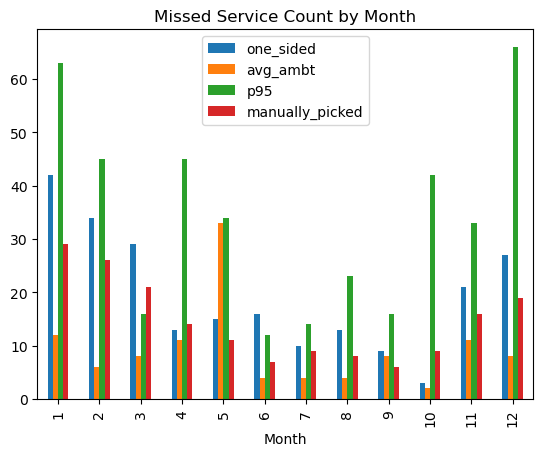

In [234]:
# missed_service_count_df.plot(use_index=True, y=lst,
#                    figsize=(18,6), ylabel='Service Coverage (Percentage)', ylim=(0,1.2))
chart_fig5 = plt.figure()
ax1=chart_fig5.add_subplot()
missed_service_count_df.plot(use_index=True, y=['one_sided','avg_ambt','p95', 'manually_picked'], ax=ax1, 
                   title="Missed Service Count by Month", kind='bar')
# plt.figure(figsize=(12,4))
plt.show()

# Exporting analysis result to Excel file:

In [235]:
writer = ExcelWriter(file_path)
df13.to_excel(writer,'segmentation data')
estimation_df.to_excel(writer,'range estimation')
missed_service_count_df.to_excel(writer, 'missed service count')
avg_temp_monthly.to_excel(writer, 'average temp monthly')
regression_params_df.to_excel(writer, 'regression analysis parameters')
workbook = writer.book
figs = [fig1, fig2, fig3, fig4]
save_chart(workbook, figs, "regression analysis")
charts = [chart_fig1, chart_fig2, chart_fig3, chart_fig4, chart_fig5]
save_chart(workbook, charts, "charts")
writer.close()

C:\Users\hotran\AppData\Local\Temp\5\ipykernel_10836\45169217.py:2: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  df13.to_excel(writer,'segmentation data')
C:\Users\hotran\AppData\Local\Temp\5\ipykernel_10836\45169217.py:3: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  estimation_df.to_excel(writer,'range estimation')
C:\Users\hotran\AppData\Local\Temp\5\ipykernel_10836\45169217.py:4: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  missed_service_count_df.to_excel(writer, 'missed service count')
C:\Users\hotran\AppData\Local\Temp\5\ipykernel_10836\45169217.py:5: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  avg_temp_monthly.to_exc

Adding chart(s) done.
Adding chart(s) done.
